In [14]:
import numpy as np
import pandas as pd
from scipy.stats import norm, beta
import matplotlib.pyplot as plt
import random

import sys
sys.path.insert(0, '../lib')
sys.path.insert(0, '../src')

import ml_estimation as ml
import model1_explore as me
import model1_plots as mp
import Utilities as util

In [2]:
y1 = beta.rvs(3, 2, size = 10)
y1

array([0.32316499, 0.82280272, 0.73142335, 0.89345216, 0.52266417,
       0.74195197, 0.53084393, 0.56418753, 0.41639554, 0.72729087])

In [3]:
# make data set
N = 1000

def drawMixBeta(N, alpha1, beta1, alpha2, beta2, p, seed = False):
    if seed:
        np.random.seed(0)
    x = np.random.rand(N)
    y1 = beta.rvs(alpha1, beta1, size = N)
    y2 = beta.rvs(alpha2, beta2, size = N)
    u  = (x < p)
    return u * y1 + ~u * y2

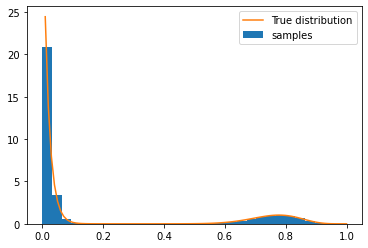

In [4]:
param = [ 0.91317788,  50.91077191, 21.52071485,  6.85876098,  0.79635204]
N = 10000
x = drawMixBeta(N, *param, seed = True)
plt.hist(x, bins = 30, density = True, label = 'samples')

x_ = np.linspace(0, 1, 100)

plt.plot(x_, ml.pdf_bmix(x_, *param), label = 'True distribution')
plt.legend()

## Maximum likelihood

In [16]:
def fitMixBeta(h_):
    mu2 = h_.mean()
    nu1 = 20
    mu1 = 1 - mu2
    nu2 = 20
    alpha1, beta1, alpha2, beta2 = mu1 * nu1 , nu1 - mu1 * nu1,  mu2 * nu2 , nu2 - mu2 * nu2
    start_params = [alpha1, beta1, alpha2, beta2, .2 ]
    
    ml_manual = ml.MyMixBetaML(h_, h_).fit(disp = 0,
                start_params = start_params)
    
#     params = fixInvalidP(ml_manual.params)
#     params = switchBeta(params)
#     conv = ml_manual.mle_retvals['converged']
    return ml_manual
print(param)
fit = fitMixBeta(x)

[0.91317788, 50.91077191, 21.52071485, 6.85876098, 0.79635204]


In [29]:
def fitMixBetaCTHtoParams(fit):
    params = me.fixInvalidP(fit.params)
    p = params[-1]
    params = me.switchBeta(params)
    bse = fit.bse
    bse[:-1] = me.switchBeta(np.hstack([fit.bse[:-1], p]))[:-1]
    return params, bse

print(fit.params, fit.bse)
fitMixBetaCTHtoParams(fit)

[20.94339569  6.61495641  0.89657797 50.10455684  0.20129992] [0.01237051 0.9046272  0.66180608 0.20365889 0.00400972]


(array([ 0.89657797, 50.10455684, 20.94339569,  6.61495641,  0.79870008]),
 array([0.66180608, 0.20365889, 0.01237051, 0.9046272 , 0.00400972]))

In [ ]:
n = 50
coef = np.zeros((n, 5))
stderr = np.zeros((n, 5))
for i in range(n):
    x = drawMixBeta(N, *param)
    fit = fitMixBeta(x)
    coef[i, :] = fit.params
    stderr[i,:] = fit.bse
    

In [9]:
# np.save('coefML.npy', coef)
# np.save('stderr.npy', stderr)

coef = np.load('coefML.npy')
stderr = np.load('stderr.npy')

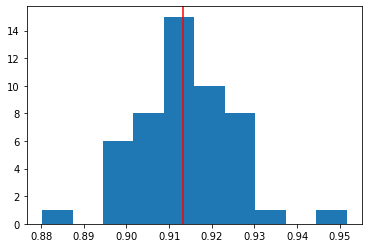

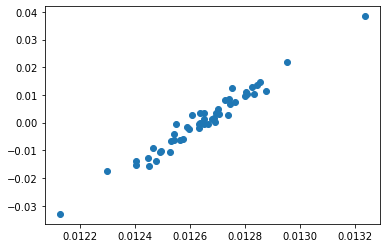

In [10]:
plt.hist(coef[:,0])
plt.axvline(param[0], color = 'red', label = 'True param')
plt.show()
plt.scatter(stderr[:,0], coef[:,0] - param[0])


In [11]:
# dir(fit)


# Moment of Methods

In [81]:
import math
def momentBM(n, alpha1, beta1, alpha2, beta2, p ):
    m = p * momentBeta(n, alpha1, beta1) + (1-p) * momentBeta(n, alpha2, beta2)
    return m

def momentBeta(n, alpha, beta):
    if n <= 0:
        out = 1
    else:
        out =  momentBeta(n - 1, alpha, beta) * (alpha + n - 1)/(alpha + beta + n - 1)
    return out
momentBeta(0, 1, 1), 1

def func(param):
    mom = np.zeros(5)
    for i in range(5):
        mom[i] = momentBM(i+1, *param)
    diff = mom - est    
    return np.sum(diff**2)

def fitMixBetaMoM(h_):
    mu1 = h_.mean()
    nu1 = 20
    mu2 = 1 - mu1
    nu2 = 20
    alpha1, beta1, alpha2, beta2 = mu1 * nu1 , nu1 - mu1 * nu1,  mu2 * nu2 , nu2 - mu2 * nu2
    start_params = [alpha1, beta1, alpha2, beta2, .8 ]
    
    ml_manual = opt.minimize(func, start_params, method='TNC', tol=1e-15)
    
#     params = fixInvalidP(ml_manual.params)
#     params = switchBeta(params)
#     conv = ml_manual.mle_retvals['converged']
    return ml_manual

param = [100, 1, 10, 2, 1]

x = drawMixBeta(int(1e4), *param, seed = True)

n = 5 
est = np.zeros(5)
for i in range(n):
    mom = momentBM(i+1, *param)
    est[i] = (x**(i+1)).mean()
    print(f'{mom:.5f}\t{est[i]:.5f}\t{mom-est[i]:.5f}')

import scipy.optimize as opt


sol = fitMixBetaMoM(x)
sol.x, func(sol.x), sol.success , param - sol.x, param
# print(param)
sol_ml = fitMixBeta(x)


0.99010	0.99015	-0.00005
0.98039	0.98049	-0.00010
0.97087	0.97102	-0.00015
0.96154	0.96173	-0.00020
0.95238	0.95262	-0.00024


[100, 1, 10, 2, 1]
[19.57293366  0.21409704  1.60241599 20.73143471  1.00138754] False
[3.05149605e+01 4.75009377e-01 9.68683528e-03 2.09779928e-08
 1.00000000e+00] True


(<class 'statsmodels.iolib.summary.Summary'>
 """
                              MyMixBetaML Results                              
 Dep. Variable:                      y   Log-Likelihood:                 34304.
 Model:                    MyMixBetaML   AIC:                        -6.861e+04
 Method:            Maximum Likelihood   BIC:                        -6.860e+04
 Date:                Fri, 21 Jan 2022                                         
 Time:                        11:26:51                                         
 No. Observations:               10000                                         
 Df Residuals:                    9999                                         
 Df Model:                           0                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 alpha1        30.5150        nan        nan        nan         nan   

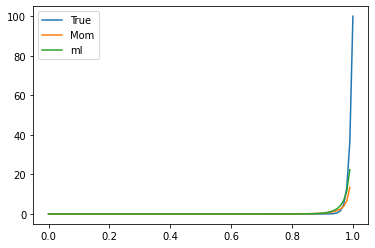

In [75]:
plt.plot(x_,ml.pdf_bmix(x_, *param), label = "True")
plt.plot(x_,ml.pdf_bmix(x_, *sol.x), label = "Mom")
plt.plot(x_,ml.pdf_bmix(x_, *(sol_ml.params)), label = 'ml')
plt.legend()

print(param)
print(sol.x, sol.success)
print(sol_ml.params, sol_ml.mle_retvals['converged'])
sol_ml.summary(), sol
# sol

In [86]:
m1 = x.mean()
m2 = (x**2).mean()
print(alpha(m1, m2), beta(m1, m2))
MoM_sb(x)

100.27338243363727 0.9974620934858935


(100.27338243363727, 0.9974620934858935)

In [85]:
def m1(alpha, beta):
    return alpha/(alpha+beta)
def m2(alpha, beta):
    return m1(alpha, beta) * m1(alpha + 1, beta)

alpha, beta = 100,1
m1, m2 = m1(alpha, beta), m2(alpha, beta)
print(m1, m2)

def MoM_sb(x):
    m1 = x.mean()
    m2 = (x**2).mean()
    alpha = m1 * (m1 - m2) /(m2 - m1**2)
    beta = (m1/m2 - 1) * (alpha +1)
    return alpha , beta

def alpha(m1, m2):
    return m1 * (m1 - m2) /(m2 - m1**2)
    
def beta(m1, m2):
    return (m1/m2 - 1) * (alpha(m1, m2) +1)
print(alpha(m1, m2), beta(m1, m2))

0.9900990099009901 0.9803921568627452
99.99999999986731 0.9999999999986872
